## Responses Analysis

### Looking into Task 1

In [6]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

  Using cached contourpy-1.3.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 3.4 MB/s  0:00:02m0:00:0100:010m
Using cached contourpy-1.3.3-cp311-cp311-macosx_10_9_x86_64.whl (288 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.2 MB/s  0:00:00 eta 0:00:01
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_10_9_x86_64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 7.1 MB/s  0:00:00 eta 0:00:01
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 9.4 MB/s  0:00:02 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Found 5 task files total.



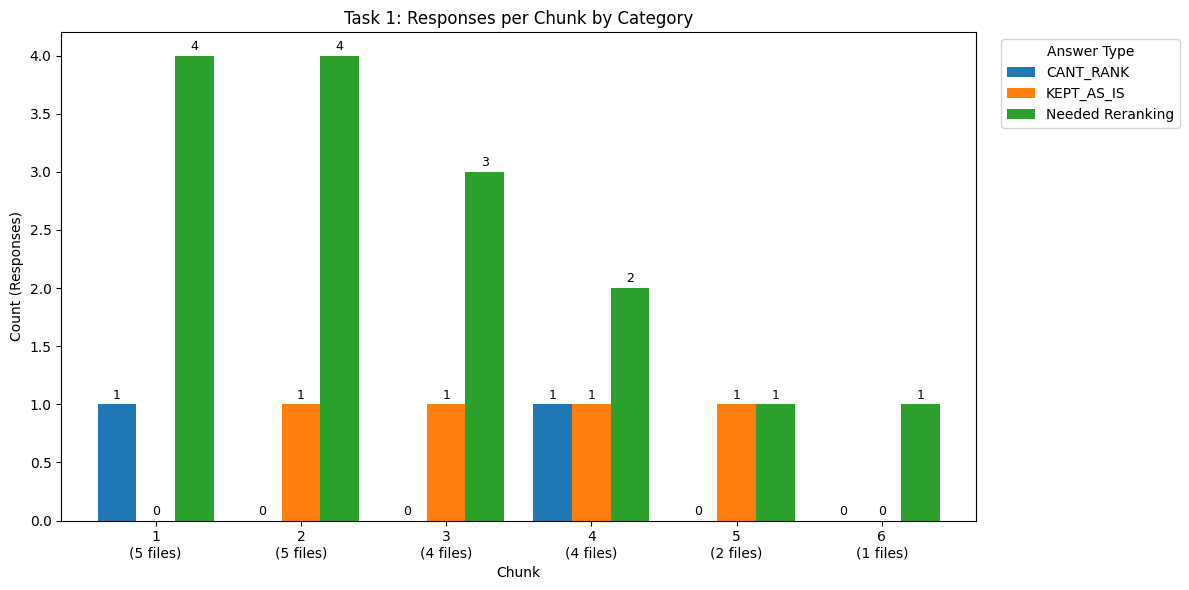


Number of files contributing to each chunk (per-file presence):
   n_files
1        5
2        5
3        4
4        4
5        2
6        1


In [56]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- Path to your responses folder ---
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/server/responses"

# --- Collect all task_1 files ---
task_files = [
    os.path.join(responses_dir, f)
    for f in os.listdir(responses_dir)
    if f.endswith("task_1.json")
]
print(f"Found {len(task_files)} task files total.\n")

# --- Read data and track chunks per file ---
records = []
chunks_by_file = {}  # file_basename -> set(chunks)

for file_path in task_files:
    basename = os.path.basename(file_path)
    with open(file_path, "r") as f:
        try:
            data = json.load(f)
        except Exception as e:
            print(f"⚠️ Failed to read {basename}: {e}")
            data = []
    seen_chunks = set()
    for entry in data:
        try:
            chunk = int(entry.get("chunk"))
        except Exception:
            continue
        answer = entry.get("answer")
        if answer == "KEPT_AS_IS":
            category = "KEPT_AS_IS"
        elif answer == "CANT_RANK":
            category = "CANT_RANK"
        elif isinstance(answer, list):
            category = "Needed Reranking"
        else:
            category = "OTHER"
        records.append({"file": basename, "chunk": chunk, "category": category})
        seen_chunks.add(chunk)
    chunks_by_file[basename] = seen_chunks

# --- Count how many files include each chunk ---
all_chunks = sorted({r["chunk"] for r in records})
files_per_chunk = {c: 0 for c in all_chunks}
for fname, chunkset in chunks_by_file.items():
    for c in chunkset:
        if c in files_per_chunk:
            files_per_chunk[c] += 1
files_per_chunk = pd.Series(files_per_chunk).sort_index()

# --- Build counts per chunk/category ---
df = pd.DataFrame(records)
counts = df.groupby(["chunk", "category"]).size().unstack(fill_value=0)
counts = counts.reindex(all_chunks, fill_value=0)

# --- Plot grouped bars ---
fig, ax = plt.subplots(figsize=(12, 6))
counts.plot(kind="bar", ax=ax, width=0.8)

# --- Title & axis labels ---
ax.set_title("Task 1: Responses per Chunk by Category")
ax.set_xlabel("Chunk")
ax.set_ylabel("Count (Responses)")

# --- X-axis labels include number of files ---
xticklabels = [f"{chunk}\n({files_per_chunk.get(chunk, 0)} files)" for chunk in counts.index]
ax.set_xticklabels(xticklabels, rotation=0)

# --- Add numeric count labels to each bar ---
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

# --- Legend and layout tweaks ---
ax.legend(title="Answer Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- Print summary table for reference ---
print("\nNumber of files contributing to each chunk (per-file presence):")
print(files_per_chunk.to_frame(name="n_files"))


In [57]:
import os
import json
from scipy.stats import spearmanr
import pandas as pd

# --- Paths ---
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/server/responses"
payloads_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/src/payloads"

# --- Find all task_1 response files ---
task1_files = [f for f in os.listdir(responses_dir) if f.endswith("task_1.json")]
print(f"Found {len(task1_files)} task_1 response files.\n")

all_records = []

for file_name in task1_files:
    annotator = file_name.replace("_responses_task_1.json", "")
    response_file = os.path.join(responses_dir, file_name)
    payload_file = os.path.join(payloads_dir, f"{annotator}-payload.json")  # assuming this naming format

    if not os.path.exists(payload_file):
        print(f"⚠️ Ground truth payload not found for {annotator}, skipping.")
        continue

    # --- Load response and ground truth ---
    with open(response_file, "r") as f:
        responses = json.load(f)
    with open(payload_file, "r") as f:
        ground_data = json.load(f)

    for entry in responses:
        paper_id = entry["paperId"]
        chunk = entry["chunk"]
        answer = entry["answer"]

        # Get ground-truth candidates for this paper/chunk
        gt_entry = next((p for p in ground_data if p["paperId"] == paper_id and str(p.get("chunk")) == str(chunk)), None)
        if not gt_entry:
            continue
        gt_answer = [c["paperId"] for c in gt_entry["candidates"]]

        if answer == "KEPT_AS_IS":
            rho = 1.0
            status = "KEPT_AS_IS"
        elif answer == "CANT_RANK":
            rho = None
            status = "CANT_RANK"
        elif isinstance(answer, list):
            common_ids = [pid for pid in answer if pid in gt_answer]
            if len(common_ids) < 2:
                rho = None
            else:
                annot_ranks = [answer.index(pid) + 1 for pid in common_ids]
                gt_ranks = [gt_answer.index(pid) + 1 for pid in common_ids]
                rho, _ = spearmanr(annot_ranks, gt_ranks)
                rho = round(rho, 3)
            status = "RERANKED"
        else:
            rho = None
            status = "UNKNOWN"

        all_records.append({
            "annotator": annotator,
            "paperId": paper_id,
            "chunk": chunk,
            "status": status,
            "spearman_r": rho
        })

# --- Build DataFrame ---
df = pd.DataFrame(all_records)

# --- Group by annotator + paperId ---
grouped = df.groupby(["annotator","paperId"]).agg(
    chunks=('chunk', list),
    statuses=('status', list),
    spearman_r_per_chunk=('spearman_r', list),
    mean_spearman=('spearman_r', lambda x: round(pd.Series(x).dropna().mean(), 3))
).reset_index()

display(grouped)


Found 5 task_1 response files.



,annotator,paperId,chunks,statuses,spearman_r_per_chunk,mean_spearman
0,austen,c6fa25f723a1a842b8452bc04d154e44186d05c1,"[1, 2, 3, 4, 5, 6]","[RERANKED, RERANKED, RERANKED, RERANKED, RERAN...","[0.143, 0.214, -0.738, 0.619, 0.548, -0.5]",0.048
1,hannah,7b489c47ebca2c1df0e611e76b9649f69e4fce29,"[1, 2]","[RERANKED, KEPT_AS_IS]","[0.857, 1.0]",0.928
2,jackc,88833319309da6d8a8d7ab0318f72f6d6f383b30,"[1, 2, 3, 4, 5]","[CANT_RANK, RERANKED, RERANKED, CANT_RANK, KEP...","[nan, -0.5, 0.786, nan, 1.0]",0.429
3,jiefu,19f59c14b3d79e3203c696128a135d33eb35e468,"[1, 2, 3, 4]","[RERANKED, RERANKED, RERANKED, RERANKED]","[0.452, 0.548, 0.429, 0.4]",0.457
4,rohan,c43cc65148bf7221ff035c75621b663371fe8250,"[1, 2, 3, 4]","[RERANKED, RERANKED, KEPT_AS_IS, KEPT_AS_IS]","[0.381, 0.286, 1.0, 1.0]",0.667


/var/folders/sg/ycytj2314dn0nb9vf68d7d3m0000gn/T/ipykernel_99144/3702462272.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


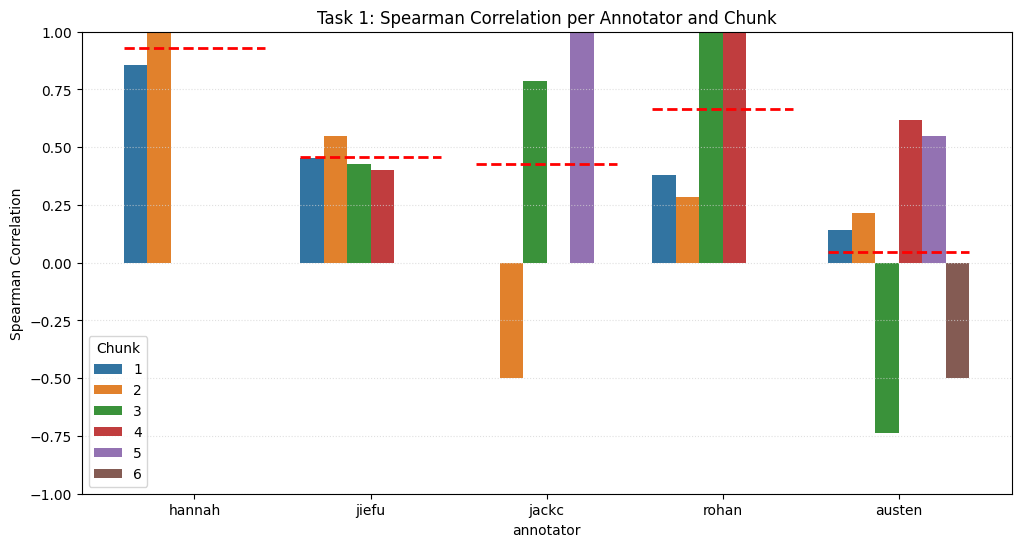

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare a copy
plot_df = df.copy()

# Convert spearman_r to float, non-numeric becomes NaN
plot_df["spearman_r_float"] = plot_df["spearman_r"].apply(lambda x: float(x) if str(x).replace('.','',1).replace('-','',1).isdigit() else np.nan)

plt.figure(figsize=(12,6))

# Barplot per chunk, disable confidence interval to show negative values correctly
ax = sns.barplot(
    data=plot_df,
    x="annotator",
    y="spearman_r_float",
    hue="chunk",
    palette="tab10",
    ci=None
)

# Light gray horizontal gridlines
ax.grid(axis='y', linestyle=':', color='lightgray', linewidth=0.8, alpha=0.7)

# Compute mean Spearman per annotator (ignores NaN)
mean_spearman = plot_df.groupby("annotator")["spearman_r_float"].mean()

# Map annotator names to x positions
xticks = ax.get_xticks()
annotators = plot_df["annotator"].unique()
annotator_pos = {a: xticks[i] for i, a in enumerate(annotators)}

# Draw mean lines at correct x positions
for annotator, mean_val in mean_spearman.items():
    x = annotator_pos[annotator]
    ax.hlines(mean_val, x - 0.4, x + 0.4, colors='red', linestyles='--', linewidth=2)

# Keep full y-axis range to show negative values
ax.set_ylim(-1, 1)
ax.set_ylabel("Spearman Correlation")
ax.set_title("Task 1: Spearman Correlation per Annotator and Chunk")
ax.legend(title="Chunk")
plt.show()


### Looking into Task 2

In [42]:
import os
import json
import pandas as pd

# --- Paths ---
responses_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/server/responses"
payloads_dir = "/Users/hannahgonzalez/Documents/JHU/RankerWebsite/ranking-annotation-UI/ranker-main/src/payloads"

# --- Find all task_2 response files ---
task2_files = [
    os.path.join(responses_dir, f)
    for f in os.listdir(responses_dir)
    if f.endswith("task_2.json")
]

print(f"Found {len(task2_files)} task_2 response files.\n")

records = []

for file_path in task2_files:
    # Infer annotator name
    base = os.path.basename(file_path)
    if not base.endswith("_responses_task_2.json"):
        continue
    annotator = base.replace("_responses_task_2.json", "")

    # Load corresponding ground truth file
    payload_file = os.path.join(payloads_dir, f"{annotator}-payload-task-2.json")
    if not os.path.exists(payload_file):
        print(f"⚠️ Ground truth payload not found for {annotator}, skipping.")
        continue

    with open(payload_file, "r") as f:
        ground_data = json.load(f)

    # Build lookup: paperId → {candidate_id: rank}
    ground_lookup = {
        entry["paperId"]: {c["paperId"]: int(c["rank"]) for c in entry["candidates"]}
        for entry in ground_data
    }

    # Load annotator responses
    with open(file_path, "r") as f:
        responses = json.load(f)

    for entry in responses:
        paper_id = entry["paperId"]
        answers = entry["answer"]
        if not isinstance(answers, list):
            continue  # skip KEPT_AS_IS etc.

        ground_ranks_dict = ground_lookup.get(paper_id, {})
        # Build list of tuples: (ground_rank, paper_id)
        ranks_with_ids = [(ground_ranks_dict.get(a), a) for a in answers if ground_ranks_dict.get(a) is not None]
        # Sort by ground truth rank
        ranks_with_ids_sorted = sorted(ranks_with_ids, key=lambda x: x[0])

        # Separate back into sorted lists
        sorted_paper_ids = [a for _, a in ranks_with_ids_sorted]
        sorted_ground_ranks = [r for r, _ in ranks_with_ids_sorted]

        records.append({
            "annotator": annotator,
            "paperId": paper_id,
            "answers_sorted_by_ground": sorted_paper_ids,
            "ground_truth_ranks_sorted": sorted_ground_ranks
        })

# --- Build DataFrame ---
df = pd.DataFrame(records)
display(df)


Found 5 task_2 response files.



,annotator,paperId,answers_sorted_by_ground,ground_truth_ranks_sorted
0,austen,c6fa25f723a1a842b8452bc04d154e44186d05c1,"[6a8dbea5e40831bd6e987c03b76487f45ac49599, 23d...","[1, 2, 6, 16, 24, 33, 39]"
1,rohan,c43cc65148bf7221ff035c75621b663371fe8250,"[590432f953b6ce1b4b36bf66a2ac65eeee567515, c74...","[2, 3, 4, 10, 13, 24]"
2,jiefu,19f59c14b3d79e3203c696128a135d33eb35e468,"[025f852b227766c3a5dc914ded6f6c0ae137c617, e78...","[1, 2, 3, 6, 10]"
3,jackc,88833319309da6d8a8d7ab0318f72f6d6f383b30,"[28e3a79454bd09a2021a91e42b4b180477796445, 1b6...","[1, 14, 19, 34]"
4,hannah,7b489c47ebca2c1df0e611e76b9649f69e4fce29,"[90abbc2cf38462b954ae1b772fac9532e2ccd8b0, 1bc...","[1, 2, 5]"
